In [ ]:
!pip install datasets >> log_datasets.txt
!pip install evaluate >> log_evaluate.txt

In [ ]:
!pip install --upgrade datasets fsspec >> log_update.txt

In [ ]:
import io
import numpy as np
import matplotlib.pyplot as plt
import torch
import evaluate
import accelerate
import itertools
from datasets import load_dataset, Image, ClassLabel
from PIL import Image as PILImage, ImageFile
from tqdm import tqdm
from transformers import ViTImageProcessor, ViTForImageClassification, pipeline, TrainingArguments, Trainer
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomApply,
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)

import seaborn as sns
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
raw_dataset = load_dataset("HazemAbdelkawy/emotions")       # dataset 1
raw_dataset_2 = load_dataset("oscarparro/emotion-images-affectnet")  # dataset 2

# Extraer los splits deseados (ej. 'train')
ds1 = raw_dataset["train"]
ds2 = raw_dataset_2["train"]

# Verifica que tengan las mismas columnas y tipos
print(ds1.column_names)
print(ds2.column_names)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train-00000-of-00001.parquet:   0%|          | 0.00/371M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/361 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/316M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/27755 [00:00<?, ? examples/s]

['image', 'question', 'answer']
['image_path', 'label', 'image']


In [ ]:
ds1 = ds1.rename_column("answer", "label")
ds1 = ds1.remove_columns(["question"])
ds2 = ds2.remove_columns(["image_path"])

In [ ]:
id2label = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

In [ ]:
# Mapear valores de int → str
def decode_label(example):
    example["label"] = id2label[example["label"]]
    return example

ds2 = ds2.map(decode_label)

Map:   0%|          | 0/27755 [00:00<?, ? examples/s]

In [ ]:
from datasets import concatenate_datasets, load_dataset
dataset = concatenate_datasets([ds1, ds2])

# Aplicar el mapeo para cambiar "anger" a "angry"
def update_label(example):
    if example["label"].lower() == "anger":
        example["label"] = "angry"
    return example

dataset = dataset.map(update_label)
dataset = dataset.filter(lambda x: x["label"] != "content")

df = dataset.to_pandas()

Map:   0%|          | 0/37155 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37155 [00:00<?, ? examples/s]

In [ ]:
labels_list = ['sad' , 'disgust' , 'angry' , 'neutral' , 'fear' , 'surprise' , 'happy']

In [ ]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = (i)
    id2label[i] = label

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'sad', 1: 'disgust', 2: 'angry', 3: 'neutral', 4: 'fear', 5: 'surprise', 6: 'happy'} 

Mapping of Labels to IDs: {'sad': 0, 'disgust': 1, 'angry': 2, 'neutral': 3, 'fear': 4, 'surprise': 5, 'happy': 6}


In [ ]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=0.2, shuffle=True, stratify_by_column="label", seed=33)

split = dataset['train'].train_test_split(test_size=0.125, shuffle=True, stratify_by_column="label", seed=33)
train_data = split['train']
val_data = split['test']
test_data = dataset['test']

print("Train data size:", len(train_data))
print("Validation data size:", len(val_data))
print("Test data size:", len(test_data))

Map:   0%|          | 0/36011 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/36011 [00:00<?, ? examples/s]

Train data size: 25207
Validation data size: 3601
Test data size: 7203


In [ ]:
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.df = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df[idx]["image"]
        label = self.df[idx]["label"]

        image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomApply([RandomRotation(45)], p=0.8),
    transforms.RandomApply([RandomAdjustSharpness(2)], p=0.3),
    transforms.RandomHorizontalFlip(0.5)
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

train_dataset = EmotionDataset(train_data, transform=transform)
val_dataset = EmotionDataset(val_data, transform=transform_test)
test_dataset = EmotionDataset(test_data, transform=transform_test)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) #Convierte 3 canales de entrada (RGB) en 32 mapas de caracteristicas, con filtro 3x3. padding mantiene el tamaño espacial
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) #Convierte 32 en 64
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) #conviertee 64 en 128
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #Reduce a la mitad el tamaño espacial (ancho y alto) de los mapas
        self.dropout = nn.Dropout(0.3) #supuestamente para evitar overfitting
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # fully connected
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # [B, 32, 64, 64] 1era convolucion
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # [B, 64, 32, 32] 2da convolucion
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # [B, 128, 16, 16] 3era convolucion
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
import time
import torch

num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo actual:", device)

model = CNN(num_classes=len(labels_list)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_val_loss = float('inf')
for epoch in range(num_epochs):
    start_time = time.time()
    # --- TRAIN ---
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()
    avg_train_loss = train_loss / total_train
    train_acc = correct_train / total_train

    # --- VALIDATION ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    avg_val_loss = val_loss / total_val
    val_acc = correct_val / total_val

    # --- Save best model ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_cnn_model.pt")

    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Tiempo: {elapsed:.1f}s")


Dispositivo actual: cuda
Epoch 01 | Train Loss: 1.6575 | Train Acc: 0.3322 | Val Loss: 1.4267 | Val Acc: 0.4440 | Tiempo: 137.6s
Epoch 02 | Train Loss: 1.4430 | Train Acc: 0.4346 | Val Loss: 1.3197 | Val Acc: 0.5018 | Tiempo: 139.7s
Epoch 03 | Train Loss: 1.3599 | Train Acc: 0.4766 | Val Loss: 1.2394 | Val Acc: 0.5279 | Tiempo: 134.4s
Epoch 04 | Train Loss: 1.3102 | Train Acc: 0.4972 | Val Loss: 1.2248 | Val Acc: 0.5243 | Tiempo: 133.5s
Epoch 05 | Train Loss: 1.2690 | Train Acc: 0.5110 | Val Loss: 1.1531 | Val Acc: 0.5643 | Tiempo: 133.5s
Epoch 06 | Train Loss: 1.2402 | Train Acc: 0.5257 | Val Loss: 1.1392 | Val Acc: 0.5690 | Tiempo: 134.0s
Epoch 07 | Train Loss: 1.2159 | Train Acc: 0.5350 | Val Loss: 1.1156 | Val Acc: 0.5915 | Tiempo: 135.0s
Epoch 08 | Train Loss: 1.1958 | Train Acc: 0.5472 | Val Loss: 1.0940 | Val Acc: 0.5915 | Tiempo: 134.8s
Epoch 09 | Train Loss: 1.1810 | Train Acc: 0.5503 | Val Loss: 1.0835 | Val Acc: 0.5948 | Tiempo: 136.3s
Epoch 10 | Train Loss: 1.1663 | Train A

In [ ]:
model.load_state_dict(torch.load("best_cnn_model.pt"))
model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)

In [ ]:
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

Accuracy: 0.6217
F1 Score: 0.5992


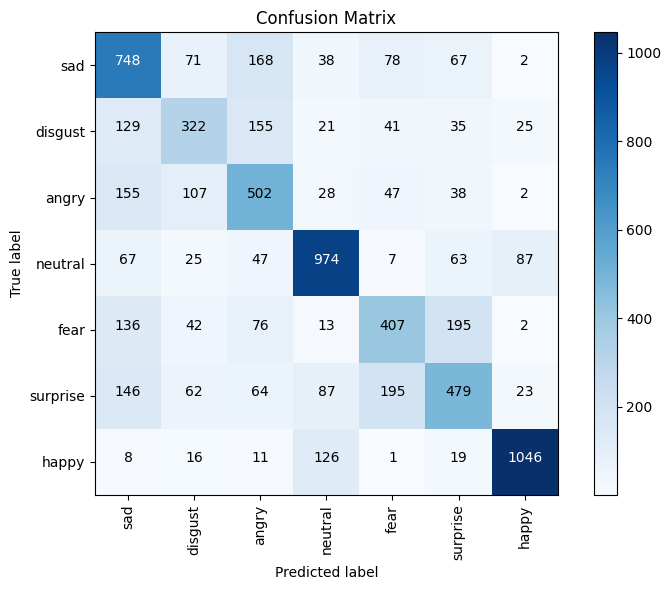


Classification report:

              precision    recall  f1-score   support

         sad     0.5385    0.6382    0.5841      1172
     disgust     0.4992    0.4423    0.4690       728
       angry     0.4907    0.5711    0.5279       879
     neutral     0.7568    0.7669    0.7618      1270
        fear     0.5245    0.4673    0.4942       871
    surprise     0.5346    0.4536    0.4908      1056
       happy     0.8812    0.8525    0.8666      1227

    accuracy                         0.6217      7203
   macro avg     0.6036    0.5988    0.5992      7203
weighted avg     0.6233    0.6217    0.6205      7203



In [ ]:
y_true = true_labels
y_pred = predictions

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))